# Multi-Tissue NODDI: Including S0 responses in regular MC models

It is well known that different tissues in the brain have different T1, T2 times and proton densities. This causes the contrast that can be seen in any usual b0 image, as the bone below.

This data slice originates from Subject 100307 of the Human Connectome Project, WU-Minn Consortium (Principal Investigators: David Van Essen and Kamil Ugurbil; 1U54MH091657) funded by the 16 NIH Institutes and Centers that support the NIH Blueprint for Neuroscience Research; and by the McDonnell Center for Systems Neuroscience at Washington University.


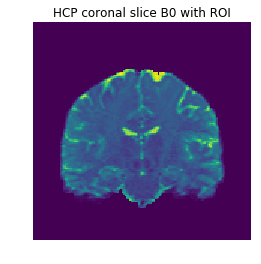

In [1]:
from dmipy.data import saved_data
scheme_hcp, data_hcp = saved_data.wu_minn_hcp_coronal_slice()

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig, ax = plt.subplots(1)
ax.imshow(data_hcp[:, 0, :, 0].T, origin=True)
ax.set_axis_off()
ax.set_title('HCP coronal slice B0 with ROI');

Multi-tissue models, such as Multi-Tissue CSD *(Jeurissen et al. 2014)*, include an estimate of the S0 value of each compartment in the volume fraction estimation. In Dmipy, go further and allow any MC-model (regular MC, MC-SM or MC-SH) to have S0 tissue responses associated with the input models. Generally, this can be described as

\begin{align}
    \textbf{p}^*(\textbf{x})=&\text{argmin}_{\textbf{p}}\int \left[S(\textbf{x},\textbf{A})-\hat{S}^{\text{MT}}(\textbf{A},\textbf{p})\right]^2d\textbf{A},\\
    &\text{with}\,\,\hat{S}^{\text{MT}}(\textbf{A},\textbf{p})=\sum_i^NS_{0,i}f_iC_i(\textbf{A},\textbf{p}_i).
\end{align}

In this example, we demonstrate Dmipy's generalized multi-tissue modeling by implemented *Multi-Tissue NODDI*. Looking at the equation, it is clear that standard multi-compartment modeling is the same as assuming the $S_0$ of each compartment is the same and equal to the $S_0$ of the measured signal. Including the good estimate of $S_{0,i}$ will correct volume fractions in areas where compartments partial volume with different $S_0$ responses.

We will show that correcting for the differences in NODDI between CSD and white matter $S_0$ responses makes signficant different in estimated volume fractions.

# Using Dmipy to set up the Multi-Tissue NODDI-Watson model

### Recovering an estimate of the WM and CSF S0 tissue responses
First we get an estimate of the $S_0$ responses of the different tissue types, so that we can include it in the NODDI model.

In [2]:
from dmipy.tissue_response.three_tissue_response import three_tissue_response_dhollander16
[S0_wm, S0_gm, S0_csf], _, _ = three_tissue_response_dhollander16(
    scheme_hcp, data_hcp, wm_algorithm='tournier07',
    wm_N_candidate_voxels=150, gm_perc=0.2, csf_perc=0.4)

print 'white matter S0 response: {}'.format(S0_wm)
print 'CSF S0 response: {}'.format(S0_csf)

white matter S0 response: 3184.17626953
CSF S0 response: 10908.4316406


Notice that the $S_0$ response of the CSF is three times higher than that of white matter.

### Setting up Multi-Tissue NODDI

We set up the NODDI-Watson model as usual first.

In [3]:
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.distributions.distribute_models import SD1WatsonDistributed
ball = gaussian_models.G1Ball()
stick = cylinder_models.C1Stick()
zeppelin = gaussian_models.G2Zeppelin()
watson_dispersed_bundle = SD1WatsonDistributed(models=[stick, zeppelin])
watson_dispersed_bundle.set_tortuous_parameter('G2Zeppelin_1_lambda_perp','C1Stick_1_lambda_par','partial_volume_0')
watson_dispersed_bundle.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
watson_dispersed_bundle.set_fixed_parameter('G2Zeppelin_1_lambda_par', 1.7e-9)

But, when instantiating the MC-model we can now also give the `S0_tissue_responses` that we previously estimated.

In [4]:
from dmipy.core.modeling_framework import MultiCompartmentModel
NODDI_mod = MultiCompartmentModel(
    models=[ball, watson_dispersed_bundle],
    S0_tissue_responses=[S0_csf, S0_wm])  # notice one value for each model.

The last thing is to fix the diffusivity of the Ball compartment to static values.

In [5]:
NODDI_mod.set_fixed_parameter('G1Ball_1_lambda_iso', 3e-9)

We can visualize the model as follows, but nothing on the composition changed, only the $S_0$ values associated with the top-level models.

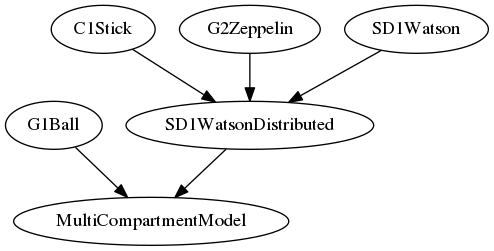

In [6]:
from IPython.display import Image
NODDI_mod.visualize_model_setup(view=False, cleanup=False)
Image('Model Setup.png')

# Fitting Multi-Tissue NODDI to Human Connectome Project data

Fitting is then the same as usual. But notice there is a second optimization happening for the multi-tissue fractions. This is because correcting for the tissue-specific $S_0$ values is independent from the estimation of the non-linear parameters of the original NODDI model.

In [7]:
NODDI_fit_hcp = NODDI_mod.fit(
    scheme_hcp, data_hcp, mask=data_hcp[..., 0]>0)

Using parallel processing with 8 workers.
Setup brute2fine optimizer in 6.95517396927 seconds
Fitting of 8181 voxels complete in 1132.75483418 seconds.
Average of 0.138461659232 seconds per voxel.
Starting secondary multi-tissue optimization.
Multi-tissue fitting of 8181 voxels complete in 28.0474832058 seconds.


## Compare volume fractions with and without including S0 responses

Once fitted, the fitted model has access to both the original and the multi-tissue fractions. Here, we can easily compare them and illustrate where the differences at the interfaces are significant.

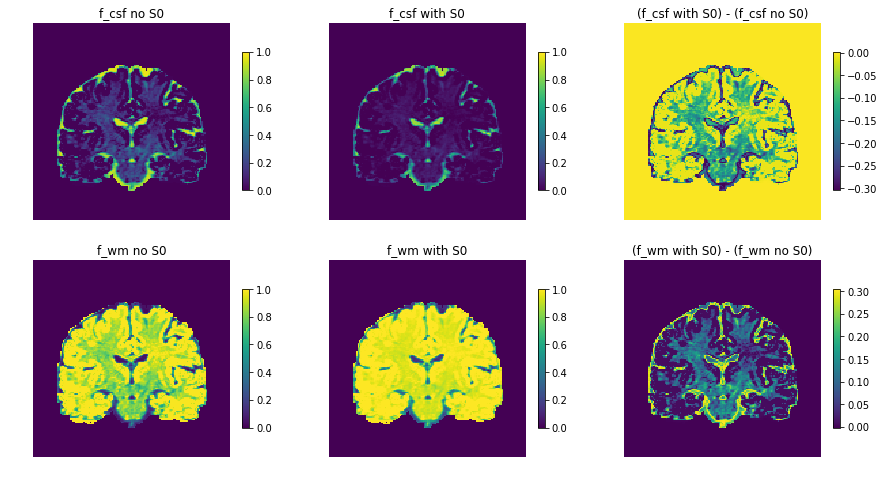

In [8]:
fractions_csf = NODDI_fit_hcp.fitted_parameters['partial_volume_0']
fractions_wm = NODDI_fit_hcp.fitted_parameters['partial_volume_1']
mt_fractions_csf = NODDI_fit_hcp.fitted_multi_tissue_fractions_normalized['partial_volume_0']
mt_fractions_wm = NODDI_fit_hcp.fitted_multi_tissue_fractions_normalized['partial_volume_1']

fig, axs = plt.subplots(2, 3, figsize=[15, 8])
axs = axs.ravel()
opts = {'origin': True, 'interpolation': 'nearest'}

im = axs[0].imshow(fractions_csf.squeeze().T, vmin=0, vmax=1, **opts)
fig.colorbar(im, ax=axs[0], shrink=0.7)
axs[0].set_title('f_csf no S0')
im = axs[1].imshow(mt_fractions_csf.squeeze().T,  vmin=0, vmax=1, **opts)
fig.colorbar(im, ax=axs[1], shrink=0.7)
axs[1].set_title('f_csf with S0')
im = axs[2].imshow((mt_fractions_csf - fractions_csf).squeeze().T, **opts)
fig.colorbar(im, ax=axs[2], shrink=0.7)
axs[2].set_title('(f_csf with S0) - (f_csf no S0)')

im = axs[3].imshow(fractions_wm.squeeze().T,vmin=0, vmax=1, **opts)
fig.colorbar(im, ax=axs[3], shrink=0.7)
axs[3].set_title('f_wm no S0')
im = axs[4].imshow(mt_fractions_wm.squeeze().T, vmin=0, vmax=1, **opts)
fig.colorbar(im, ax=axs[4], shrink=0.7)
axs[4].set_title('f_wm with S0')
im = axs[5].imshow((mt_fractions_wm - fractions_wm).squeeze().T, **opts)
fig.colorbar(im, ax=axs[5], shrink=0.7)
axs[5].set_title('(f_wm with S0) - (f_wm no S0)')

for ax in axs:
    ax.set_axis_off()

## Discussion of results

As you can see, including the estimated $S_0$ responses for CSF and WM for the corresponding models makes a significant difference in the estimated volume fractions. In fact, by including an estimate of the S0 response, we are in earnest estimated a **volume** fraction giving a certain signal contribution, rather than just the **signal** fraction contribution.

As the CSF $S_0$ response is about 3x higher than that of WM, that means that the same volume of CSF tissue produces 3x more signal to the $b_0$ than the same volume of WM. By (approximately) correcting for this bias, we can see that at the interfaces between CSF and WM, the actual volume fraction can be more than 0.3 higher than estimated without the $S_0$ response. In practice, this means that the white matter bundles such as the corpus callosum grow a little more into the CSF volume, making them bigger.

In conclusion, any MC-model that models tissues with different $S_0$ responses should include an estimate of the values -- if possible. Otherwise, the estimated volume fractions will **always** be biased in the direction of the difference of the tissues' $S_0$ responses.

## References
- Zhang, Hui, et al. "NODDI: practical in vivo neurite orientation dispersion and density imaging of the human brain." Neuroimage 61.4 (2012): 1000-1016.
- Jeurissen, Ben, et al. "Multi-tissue constrained spherical deconvolution for improved analysis of multi-shell diffusion MRI data." NeuroImage 103 (2014): 411-426.